In [141]:
# ! pip install gensim
# ! pip install tqdm
# ! pip install sklearn
! pip install nltk

    100% |████████████████████████████████| 3.1MB 10.6MB/s ta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/97/8a/10/d646015f33c525688e91986c4544c68019b19a473cb33d3b55
Successfully built nltk
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [142]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [143]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from gensim.models.fasttext import FastText as FT_gensim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pylab as plt
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K
import re
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.layers import Layer
from nltk.corpus import stopwords

In [6]:
Model = keras.Model

Dense = keras.layers.Dense
TimeDistributed = keras.layers.TimeDistributed
GlobalMaxPooling1D = keras.layers.GlobalMaxPooling1D
GlobalAveragePooling1D = keras.layers.GlobalAveragePooling1D
Dropout = keras.layers.Dropout
Input = keras.layers.Input
Add = keras.layers.Add

l1 = keras.regularizers.l1
l2 = keras.regularizers.l2
l1_l2 = keras.regularizers.l1_l2

Adam = keras.optimizers.Adam
SGD = keras.optimizers.SGD
Adagrad = keras.optimizers.Adagrad

In [8]:
class roc_auc_callback(keras.callbacks.Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x, verbose=0)
        roc = roc_auc_score(self.y, y_pred)
        logs['roc_auc'] = roc_auc_score(self.y, y_pred)
#         logs['norm_gini'] = ( roc_auc_score(self.y, y_pred) * 2 ) - 1

        y_pred_val = self.model.predict(self.x_val, verbose=0)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        logs['roc_auc_val'] = roc_auc_score(self.y_val, y_pred_val)
#         logs['norm_gini_val'] = ( roc_auc_score(self.y_val, y_pred_val) * 2 ) - 1

        print('\rROC-AUC: {} - ROC-AUC-VAL: {}'.format(str(round(roc,5)),str(round(roc_val,5))) + 10*' ')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [9]:
def plt_all_hist(all_hist, from_ = 0):
    all_e = []
    all_l = []
    all_vl = []
    all_ra = []
    all_vra = []
    for hist in all_hist:
        if len(hist.history) > 0:
            all_e = all_e + hist.epoch
            all_l = all_l + hist.history['loss']
            all_vl = all_vl + hist.history['val_loss']
            all_ra = all_ra + hist.history['roc_auc']
            all_vra = all_vra + hist.history['roc_auc_val']
            
    plt.figure(figsize=(20, 10))
    plt.plot(all_e[from_:], all_l[from_:], label='Loss')
    plt.plot(all_e[from_:], all_vl[from_:], label='Val Loss')
    plt.legend(loc='best')
    plt.title('Loss')
    plt.show()
    
    plt.figure(figsize=(20, 10))
    plt.plot(all_e[from_:], all_ra[from_:], label='AUC-ROC')
    plt.plot(all_e[from_:], all_vra[from_:], label='Val AUC-ROC')
    plt.legend(loc='best')
    plt.title('ROC-AUC')
    plt.show()

In [10]:
class SenAv(Layer):

    def __init__(self, **kwargs):
        super(SenAv, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='W_matrix', 
                                 shape=tf.TensorShape((input_shape[2], input_shape[2])),
                                 initializer='uniform',
                                 trainable=True)
        super(SenAv, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        ys = K.mean(x, axis=1)
        
        d = K.dot(ys, self.W)
        d = tf.expand_dims(d, axis=1)
        d = K.sum(x * d, axis=2)
        
        a = K.softmax(d, axis=1)
        a = tf.expand_dims(a, axis=2)
        
        return K.sum(x * a, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.input_shape[2])

In [11]:
# i = Input(shape = (50, 300))
# x = SenAv()(i)
# x = Dense(1)(x)
# model = Model(inputs=i, outputs=x)

In [12]:
# model.summary()

In [13]:
# model.compile(Adam(0.001), loss='binary_crossentropy', metrics=['binary_crossentropy'])

In [14]:
class RecLay(Layer):
    def __init__(self, K, **kwargs):
        self.K = K
        super(RecLay, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='W_matrix', 
                                 shape=tf.TensorShape((input_shape[1], self.K)),
                                 initializer='uniform',
                                 trainable=True)
        self.b = self.add_weight(name='bias', 
                                 shape=tf.TensorShape((1, self.K,)),
                                 initializer='uniform',
                                 trainable=True)
        
        self.T = self.add_weight(name='T_matrix',
                                 shape=tf.TensorShape((self.K, input_shape[1])),
                                 initializer='uniform',
                                 trainable=True)
        super(RecLay, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        p = K.softmax(K.dot(x, self.W) + self.b, axis=1)
        return K.dot(p, self.T)
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.input_shape[1])

In [15]:
class Mark1(object):
    def __init__(self, max_num_words=50, dim=300, ae_domains=10):
        self.max_num_words = max_num_words
        self.dim = dim
        self.aed = ae_domains
    
    def build_model(self):
        i = Input(shape = (self.max_num_words, self.dim))
        att = SenAv()(i)
        ae = RecLay(self.aed)(att)
        cl = Dense(1, activation='sigmoid')(ae)
        self.model = Model(inputs=i, outputs=ae)
    
    def compute_ae_loss(self, data):
        

SyntaxError: unexpected EOF while parsing (<ipython-input-15-e7603a9ddf1e>, line 15)

In [16]:
loaded = np.load('data/vectorized_data.npz')
data, ratings, marked_vec_data, marked_labels = [loaded[i] for i in loaded.files]
train_data, test_data, train_target, test_target = train_test_split(data, ratings, test_size=0.2, random_state=42)

In [17]:
i = Input(shape = (50, 300))
att = SenAv()(i)
ae = RecLay(10)(att)
cl = Dense(1, activation='sigmoid')(ae)
model = Model(inputs=i, outputs=cl)
model.compile(Adam(), loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50, 300)           0         
_________________________________________________________________
sen_av_4 (SenAv)             (None, 300)               90000     
_________________________________________________________________
rec_lay_3 (RecLay)           (None, 300)               6010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 96,311
Trainable params: 96,311
Non-trainable params: 0
_________________________________________________________________


In [19]:
! mkdir -p models/abaem1

In [20]:
callbacks = [
    roc_auc_callback((train_data, train_target), (test_data, test_target)),
    keras.callbacks.ModelCheckpoint('models/abaem1/model.{epoch:02d}-{val_loss:.5f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-7)
]

In [25]:
all_hist = []

In [45]:
model.fit(train_data, train_target, 
          batch_size=32, epochs=100, 
          callbacks=callbacks,
          validation_data=(test_data, test_target))
all_hist.append(model.history)

Train on 25928 samples, validate on 6483 samples
Epoch 1/100
ROC-AUC: 0.81333 - ROC-AUC-VAL: 0.7133          TA: 0s - loss: 0.5032 - binary_crossentropy: 0.5032 - acc: 0.7268
25928/25928 [==============================] - 8s 311us/step - loss: 0.5031 - binary_crossentropy: 0.5031 - acc: 0.7268 - val_loss: 0.6395 - val_binary_crossentropy: 0.6395 - val_acc: 0.6665
Epoch 2/100
ROC-AUC: 0.81509 - ROC-AUC-VAL: 0.71263          A: 0s - loss: 0.5008 - binary_crossentropy: 0.5008 - acc: 0.7273
25928/25928 [==============================] - 8s 313us/step - loss: 0.5008 - binary_crossentropy: 0.5008 - acc: 0.7273 - val_loss: 0.6354 - val_binary_crossentropy: 0.6354 - val_acc: 0.6664
Epoch 3/100
ROC-AUC: 0.81656 - ROC-AUC-VAL: 0.71041          A: 0s - loss: 0.4986 - binary_crossentropy: 0.4986 - acc: 0.7315
25928/25928 [==============================] - 8s 308us/step - loss: 0.4986 - binary_crossentropy: 0.4986 - acc: 0.7316 - val_loss: 0.6419 - val_binary_crossentropy: 0.6419 - val_acc: 0.6667


ROC-AUC: 0.84953 - ROC-AUC-VAL: 0.69918          A: 0s - loss: 0.4494 - binary_crossentropy: 0.4494 - acc: 0.7623
25928/25928 [==============================] - 8s 307us/step - loss: 0.4494 - binary_crossentropy: 0.4494 - acc: 0.7621 - val_loss: 0.7576 - val_binary_crossentropy: 0.7576 - val_acc: 0.6585
Epoch 52/100
ROC-AUC: 0.84964 - ROC-AUC-VAL: 0.69933          A: 0s - loss: 0.4497 - binary_crossentropy: 0.4497 - acc: 0.7615
25928/25928 [==============================] - 8s 307us/step - loss: 0.4493 - binary_crossentropy: 0.4493 - acc: 0.7619 - val_loss: 0.7557 - val_binary_crossentropy: 0.7557 - val_acc: 0.6597
Epoch 53/100
ROC-AUC: 0.84981 - ROC-AUC-VAL: 0.69929          A: 0s - loss: 0.4493 - binary_crossentropy: 0.4493 - acc: 0.7617
25928/25928 [==============================] - 8s 315us/step - loss: 0.4492 - binary_crossentropy: 0.4492 - acc: 0.7617 - val_loss: 0.7556 - val_binary_crossentropy: 0.7556 - val_acc: 0.6608
Epoch 54/100
ROC-AUC: 0.84997 - ROC-AUC-VAL: 0.69954       

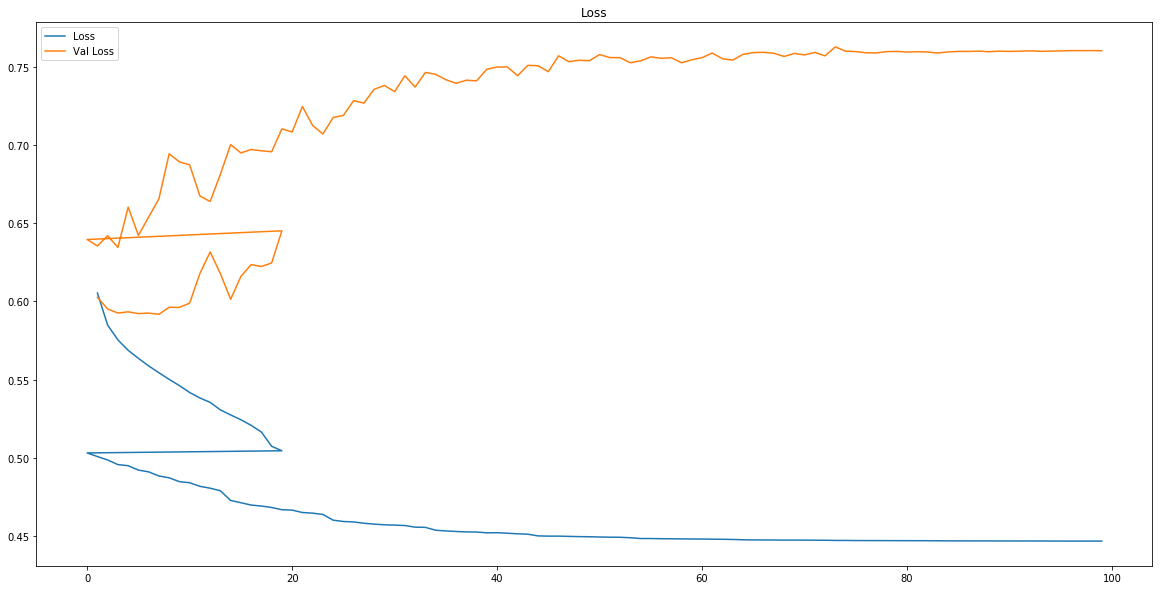

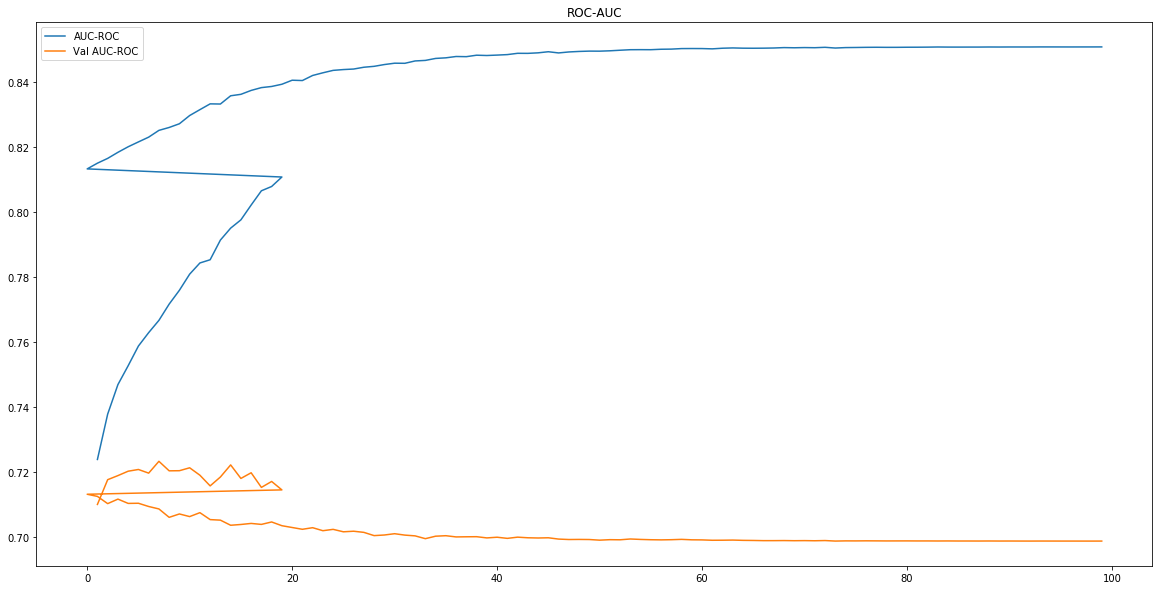

In [46]:
plt_all_hist(all_hist, 1)

In [47]:
p = model.predict(marked_vec_data)
roc_auc_score(marked_labels, p)

0.7256669069935111

In [32]:
model.layers[2].output

<tf.Tensor 'rec_lay_3/MatMul_1:0' shape=(?, 300) dtype=float32>

In [34]:
inf_model = Model(inputs=model.input, outputs=model.layers[2].output)

In [35]:
themes = inf_model.predict(marked_vec_data)

In [37]:
np.savez_compressed('themes.npz', themes)

In [41]:
model.layers[2].T

<tf.Variable 'rec_lay_3/T_matrix:0' shape=(10, 300) dtype=float32>

In [50]:
np.savez_compressed('themes.npz', K.eval(model.layers[2].T))

# Trash

In [81]:
num_heads = 10

def build_attention(x):
    return TimeDistributed(Dense(1))(x)

# def custom_loss(model):
#     inf_model = Model(inputs=model.input,
#                          outputs=model.layers[-3].output)
#     def loss(y_true, y_pred):
#         scores = inf_model
#         return K.binary_crossentropy(y_true, y_pred) + 

i = Input(shape = (50, 300))
atts = [build_attention(i) for j in range(num_heads)]
atts = keras.layers.Maximum()(atts)
av = keras.layers.Conv1D(1, 50, use_bias=False, kernel_regularizer=l1(0.01))(atts)

s = keras.layers.Lambda(lambda x: keras.activations.sigmoid(K.squeeze(x, -1)))(av)
model = Model(inputs=i, outputs=s)

model.compile(Adam(), loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 50, 300)      0                                            
__________________________________________________________________________________________________
time_distributed_70 (TimeDistri (None, 50, 1)        301         input_8[0][0]                    
__________________________________________________________________________________________________
time_distributed_71 (TimeDistri (None, 50, 1)        301         input_8[0][0]                    
__________________________________________________________________________________________________
time_distributed_72 (TimeDistri (None, 50, 1)        301         input_8[0][0]                    
__________________________________________________________________________________________________
time_distr

In [82]:
! mkdir -p models/trash2

In [83]:
callbacks = [
    roc_auc_callback((train_data, train_target), (test_data, test_target)),
    keras.callbacks.ModelCheckpoint('models/trash2/model.{epoch:02d}-{val_loss:.5f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-7)
]

In [84]:
all_hist = []

In [85]:
model.fit(train_data, train_target, 
          batch_size=32, epochs=100, 
          callbacks=callbacks,
          validation_data=(test_data, test_target),
          initial_epoch=0)

all_hist.append(model.history)

Train on 25928 samples, validate on 6483 samples
Epoch 1/100
ROC-AUC: 0.62509 - ROC-AUC-VAL: 0.61102          A: 0s - loss: 0.6816 - binary_crossentropy: 0.6604 - acc: 0.6210
25928/25928 [==============================] - 17s 671us/sample - loss: 0.6816 - binary_crossentropy: 0.6604 - acc: 0.6210 - val_loss: 0.6696 - val_binary_crossentropy: 0.6583 - val_acc: 0.6153
Epoch 2/100
ROC-AUC: 0.67438 - ROC-AUC-VAL: 0.65778          A: 0s - loss: 0.6604 - binary_crossentropy: 0.6477 - acc: 0.6235
25928/25928 [==============================] - 13s 497us/sample - loss: 0.6604 - binary_crossentropy: 0.6477 - acc: 0.6235 - val_loss: 0.6606 - val_binary_crossentropy: 0.6459 - val_acc: 0.6156
Epoch 3/100
ROC-AUC: 0.6916 - ROC-AUC-VAL: 0.67893          TA: 0s - loss: 0.6484 - binary_crossentropy: 0.6294 - acc: 0.6329
25928/25928 [==============================] - 14s 542us/sample - loss: 0.6484 - binary_crossentropy: 0.6293 - acc: 0.6332 - val_loss: 0.6506 - val_binary_crossentropy: 0.6268 - val_acc

Epoch 27/100
ROC-AUC: 0.73553 - ROC-AUC-VAL: 0.71828          A: 0s - loss: 0.6046 - binary_crossentropy: 0.5830 - acc: 0.6782
25928/25928 [==============================] - 12s 481us/sample - loss: 0.6046 - binary_crossentropy: 0.5830 - acc: 0.6781 - val_loss: 0.6178 - val_binary_crossentropy: 0.5955 - val_acc: 0.6637
Epoch 28/100
ROC-AUC: 0.73579 - ROC-AUC-VAL: 0.71756          A: 0s - loss: 0.6041 - binary_crossentropy: 0.5825 - acc: 0.6778
25928/25928 [==============================] - 12s 481us/sample - loss: 0.6041 - binary_crossentropy: 0.5825 - acc: 0.6779 - val_loss: 0.6187 - val_binary_crossentropy: 0.5965 - val_acc: 0.6602
Epoch 29/100
ROC-AUC: 0.73663 - ROC-AUC-VAL: 0.71865          A: 0s - loss: 0.6038 - binary_crossentropy: 0.5823 - acc: 0.6772
25928/25928 [==============================] - 13s 508us/sample - loss: 0.6037 - binary_crossentropy: 0.5822 - acc: 0.6774 - val_loss: 0.6169 - val_binary_crossentropy: 0.5950 - val_acc: 0.6603
Epoch 30/100
ROC-AUC: 0.737 - ROC-AUC

Epoch 53/100
ROC-AUC: 0.74513 - ROC-AUC-VAL: 0.71925          A: 0s - loss: 0.5953 - binary_crossentropy: 0.5753 - acc: 0.6834
25928/25928 [==============================] - 12s 472us/sample - loss: 0.5952 - binary_crossentropy: 0.5752 - acc: 0.6837 - val_loss: 0.6144 - val_binary_crossentropy: 0.5941 - val_acc: 0.6647
Epoch 54/100
ROC-AUC: 0.74557 - ROC-AUC-VAL: 0.72083          A: 0s - loss: 0.5946 - binary_crossentropy: 0.5744 - acc: 0.6871
25928/25928 [==============================] - 13s 496us/sample - loss: 0.5947 - binary_crossentropy: 0.5746 - acc: 0.6869 - val_loss: 0.6133 - val_binary_crossentropy: 0.5932 - val_acc: 0.6622
Epoch 55/100
ROC-AUC: 0.74528 - ROC-AUC-VAL: 0.7194          TA: 0s - loss: 0.5946 - binary_crossentropy: 0.5746 - acc: 0.6851
25928/25928 [==============================] - 12s 475us/sample - loss: 0.5945 - binary_crossentropy: 0.5745 - acc: 0.6853 - val_loss: 0.6139 - val_binary_crossentropy: 0.5940 - val_acc: 0.6657
Epoch 56/100
ROC-AUC: 0.74582 - ROC-A

ROC-AUC: 0.75023 - ROC-AUC-VAL: 0.72093          A: 0s - loss: 0.5893 - binary_crossentropy: 0.5698 - acc: 0.6889
25928/25928 [==============================] - 12s 454us/sample - loss: 0.5894 - binary_crossentropy: 0.5699 - acc: 0.6888 - val_loss: 0.6123 - val_binary_crossentropy: 0.5930 - val_acc: 0.6620
Epoch 79/100
ROC-AUC: 0.75031 - ROC-AUC-VAL: 0.7217          TA: 0s - loss: 0.5892 - binary_crossentropy: 0.5698 - acc: 0.6894
25928/25928 [==============================] - 12s 454us/sample - loss: 0.5892 - binary_crossentropy: 0.5698 - acc: 0.6895 - val_loss: 0.6126 - val_binary_crossentropy: 0.5931 - val_acc: 0.6633
Epoch 80/100
ROC-AUC: 0.75036 - ROC-AUC-VAL: 0.72185          A: 0s - loss: 0.5892 - binary_crossentropy: 0.5700 - acc: 0.6895

Epoch 00080: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
25928/25928 [==============================] - 13s 482us/sample - loss: 0.5892 - binary_crossentropy: 0.5700 - acc: 0.6895 - val_loss: 0.6126 - val_binary_crossent

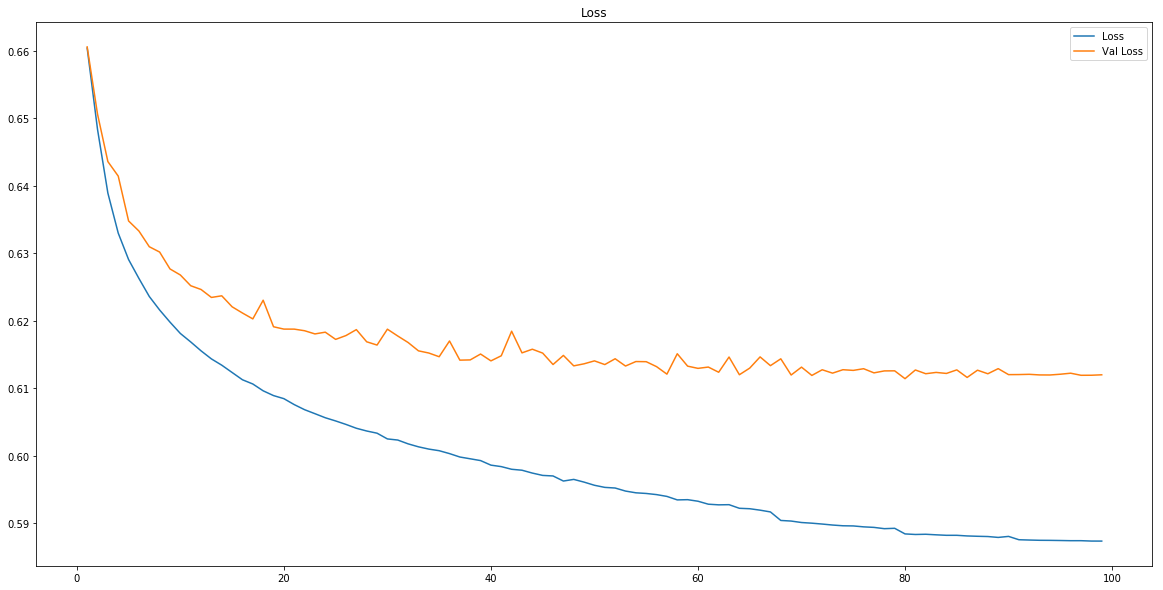

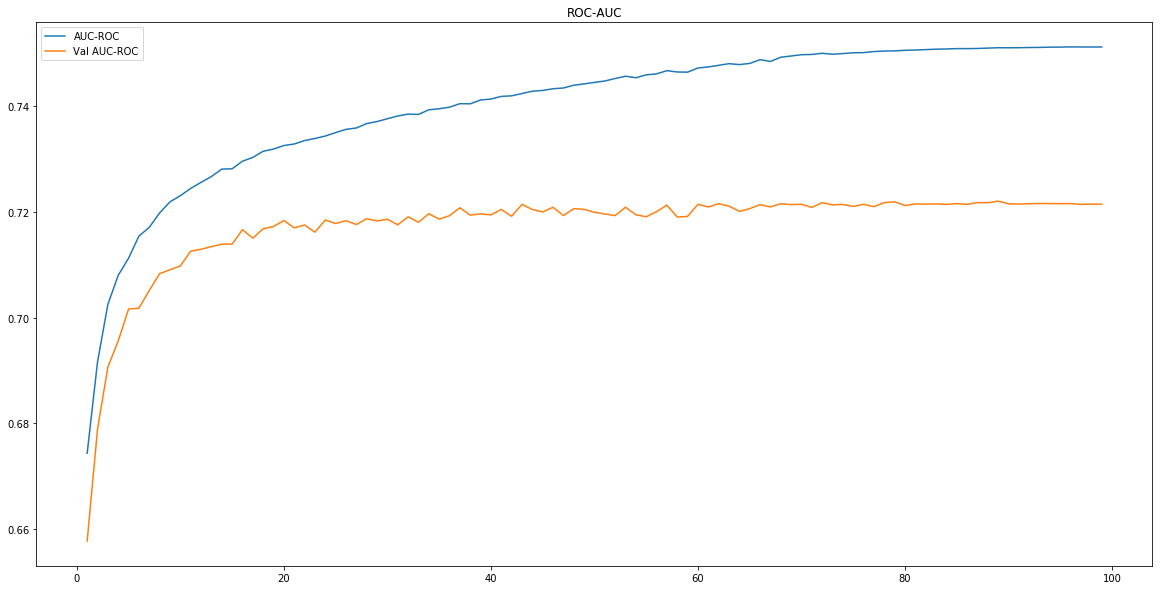

In [86]:
plt_all_hist(all_hist, 1)

In [87]:
p = model.predict(test_data)
roc_auc_score(test_target, p)

0.7213999484950897

In [ ]:
# p = model.predict(marked_vec_data)
# roc_auc_score(marked_labels, p)

In [28]:
# text_path = 'data/norm_texts.csv'
# ratings_path = 'data/norm_ratings'

# texts = open(text_path).readlines()
# ratings = open(ratings_path).readlines()

# for j, i in enumerate(ratings):
#     if i == '\n':
#         del texts[j]
#         del texts[j]
#         del ratings[j]
#         del ratings[j]

# ratings = np.array(ratings, dtype=int)
# ratings[ratings >= 0] = 1
# ratings[ratings < 0] = 0
# en_model = FT_gensim.load_fasttext_format('models/cc.ru.300.bin')

# max_num_words = 50
# pattern = re.compile('[\W_]+')
# data = np.zeros((len(texts), max_num_words, 300))

# for i, text in tqdm(enumerate(texts)):
#     counter = 0
#     for word in pattern.sub(' ', text).lower().split(' '):
#         if max_num_words == counter:
#             break
#         try:
#             data[i, counter] = en_model[word]
#             counter += 1
#         except:
#             pass
        
# def read_marked_data(path):
#     f = open(path)
#     data = []
#     cur_dict = dict()
#     for line in tqdm(f):
#         line = line.rstrip()
#         if line[:2] == 'ID':
#             cur_dict['ID'] = line[4:]
#         elif line[:len('Companies')] == 'Companies':
#             cur_dict['Companies'] = line[len('Companies') + 1:].split(',')
#         elif line[:4] == 'Text':
#             cur_dict['Text'] = line[5:]
#         elif line[:4] == 'Mark':
#             cur_dict['Mark'] = float(line[5:])
#         elif line[:2] == 'GT':
#             if len(line) > 3:
#                 cur_dict['GT'] = int(line[-1])
#                 data.append(cur_dict)
#             cur_dict = dict()
#     return data

# marked_data = read_marked_data('news_for_marks') \
#             + read_marked_data('scored_texts_ft_wokm_added_marked_data1')\
#             + read_marked_data('scored_texts_ft_wokm_added_marked_data2')\
#             + read_marked_data('scored_texts_ft_wokm')

# marked_vec_data = np.zeros((len(marked_data), max_num_words, 300))
# marked_labels = np.zeros(len(marked_data))

# for i, md in tqdm(enumerate(marked_data)):
#     marked_labels[i] = md['GT']
#     counter = 0
#     for w in pattern.sub(' ', md['Text']).lower().split(' '):
#         if counter == max_num_words:
#             break
#         try:
#             marked_vec_data[i, counter] = en_model[w]
#             counter += 1
#         except:
            pass

14120it [00:00, 259120.62it/s]
15014it [00:00, 280084.15it/s]
14120it [00:00, 269962.54it/s]
13169it [00:00, 252955.19it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
241it [00:00, 1319.50it/s]


In [31]:
def apply_model(texts, en_model, nn_model, num_layer):
    intermediate_layer_model = Model(inputs=nn_model.input,
                                     outputs=nn_model.layers[num_layer].output)
    all_words = []
    vec_words = np.zeros((len(texts), max_num_words, 300))
    pattern = re.compile('[\W_]+')
    for i, text in enumerate(texts):
        counter = 0
        words = []
        for w in pattern.sub(' ', text).lower().split(' '):
            if max_num_words == counter:
                break
            try:
                vec_words[i, counter] = en_model[w]
                counter += 1
                words.append(w)
            except:
                pass
        all_words.append(words)
    
    output = intermediate_layer_model.predict(vec_words)
    predict = nn_model.predict(vec_words)
    return all_words, output, predict

In [90]:
i = 1
print(marked_data[i]['Text'])
words, scores, predict = apply_model([marked_data[i]['Text']], en_model, model, -3)
res = sorted([(s, w) for w, s in zip(words[0], scores.squeeze())], key=lambda x: x[0])
print(marked_labels[i], predict)
if marked_labels[i] == 0:
    print (res[:10])
else:
    print (res[-10:])

 Центральный банк России с 6 декабря аннулировал лицензию на осуществление операций у краснодарский кредитной организации АО «Си Ди Би Банк» (CDB Bank). Соответствующий приказ опубликован на сайте регулятора.Лицензия аннулирована в связи с решением уполномоченного органа организации о прекращении деятельности в порядке добровольной ликвидации. В пресс-службе Банка России отмечают, что АО «Си Ди Би Банк», исходя из представленных отчетных данных, располагает достаточным имуществом для удовлетворения требований кредиторов.АО «Си Ди Би Банк» - участник системы страхования вкладов. Согласно закону, предусмотрена выплата вкладчикам страхового возмещения в размере 100% остатка средств, но не более 1,4 млн рублей в совокупности.Согласно данным отчетности, по величине активов АО «Си Ди Би Банк» на 1 ноября занимало 469 место в банковской системе России.Как сообщал сайт «Деловая газета.Юг», ранее ЦБ РФ лишил лицензии на осуществление операций краснодарский банк «Первомайский». Решение об отзыве

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


0.0 [[0.781559]]
[(-2.1151843, 'пресс'), (-0.7845092, 'приказ'), (-0.7744982, 'ликвидации'), (-0.64735043, 'опубликован'), (-0.6181103, '6'), (-0.37332082, 'о'), (-0.2963344, 'декабря'), (0.0007877946, 'прекращении'), (0.008361697, 'на'), (0.008361697, 'на')]


In [55]:
words, scores, predict = apply_model([marked_data[i]['Text'] for i in range(len(marked_data))], en_model, model, -3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


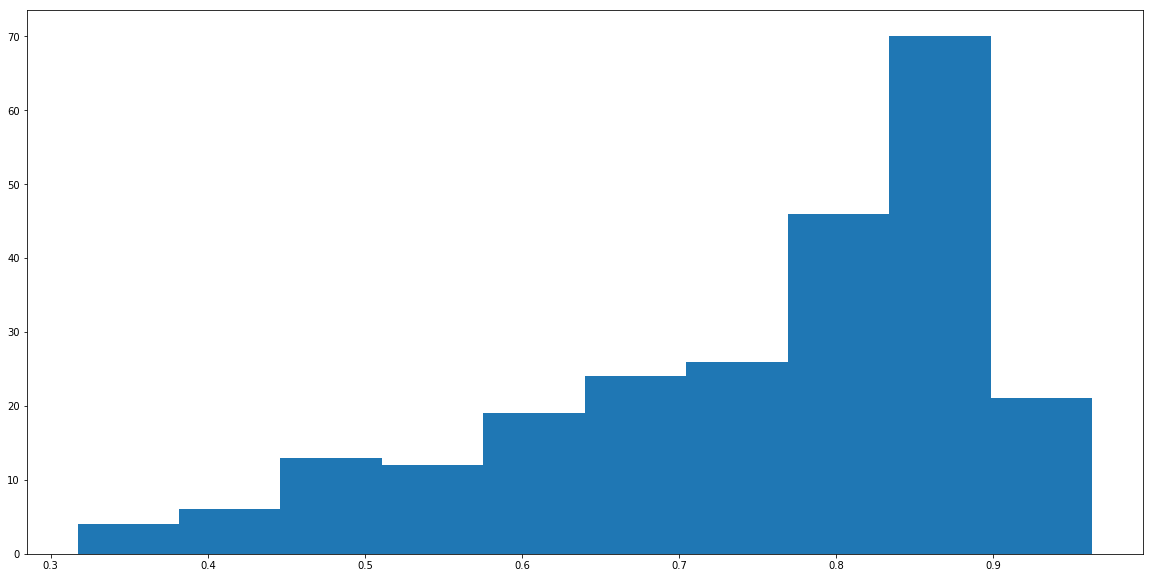

In [57]:
plt.figure(figsize = (20, 10))
plt.hist(predict.squeeze(), bins=10)
plt.show()

In [58]:
f = open('trash_words_test.txt', 'w')
for i in range(len(marked_data)):
    print('Text:', marked_data[i]['Text'], file=f)
    res = sorted([(s, w) for w, s in zip(words[i], scores[i].squeeze())], key=lambda x: x[0])
    print('Label:', int(marked_labels[i]), file=f)
    print('Predicted:', int(predict[i][0] > 0.8), file=f)
    print('Probabilty:', predict[i][0], file=f)
#     key_words = ', '.join(['{}: {}'.format(word, score) for score, word in res[:10]])\
#                 if predict[i] <= 0.8 else\
#                 ', '.join(['{}: {}'.format(word, score) for score, word in res[-10:][::-1]])
    print('Key words:', res, file=f)
    print('-' * 50, file=f)
#     if predict[i] <= 0.8:
#         print (res[:10])
#     else:
#         print (res[-10:])
f.close()

# word trash

In [91]:
word_stats = dict()
for line in open('word_rating.csv'):
    line = line.split(';')
    word_stats.setdefault(line[0], []).append(float(line[1]))

In [100]:
word_data_vec = np.zeros((len(word_stats), 300))
word_rating = np.zeros(len(word_stats)) + np.nan
for i, (word, rates) in tqdm(enumerate(word_stats.items())):
    word_data_vec[i] = en_model[word]
    word_rating[i] = np.mean(rates)

0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
6860it [00:00, 40295.56it/s]


In [103]:
np.any(np.isnan(word_rating))

False

In [104]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [119]:
i = Input(shape = (300,))
d = Dense(1)(i)
model = Model(inputs=i, outputs=d)

model.compile(Adam(), loss='mse', metrics=['mse', r2_keras])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 300)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 301       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [120]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-7)
]

In [121]:
all_hist = []

In [122]:
model.fit(word_data_vec, word_rating,
         batch_size=128,
         epochs=500,
         initial_epoch=0,
         callbacks=callbacks)

Epoch 1/500
6860/6860 [==============================] - 1s 96us/sample - loss: 0.3573 - mean_squared_error: 0.3573 - r2_keras: -0.0414
Epoch 2/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.3076 - mean_squared_error: 0.3076 - r2_keras: 0.1032
Epoch 3/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.2806 - mean_squared_error: 0.2806 - r2_keras: 0.1828
Epoch 4/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.2594 - mean_squared_error: 0.2594 - r2_keras: 0.2456
Epoch 5/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.2426 - mean_squared_error: 0.2426 - r2_keras: 0.2917
Epoch 6/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.2295 - mean_squared_error: 0.2295 - r2_keras: 0.3319
Epoch 7/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.2190 - mean_squared_error: 0.2190 - r2_keras: 0.3616
Epoch 8/500
6860/6860 [==============================]

6860/6860 [==============================] - 0s 26us/sample - loss: 0.1655 - mean_squared_error: 0.1655 - r2_keras: 0.5153
Epoch 62/500
6860/6860 [==============================] - 0s 27us/sample - loss: 0.1654 - mean_squared_error: 0.1654 - r2_keras: 0.5125
Epoch 63/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1653 - mean_squared_error: 0.1653 - r2_keras: 0.5144
Epoch 64/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1653 - mean_squared_error: 0.1653 - r2_keras: 0.5159
Epoch 65/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1653 - mean_squared_error: 0.1653 - r2_keras: 0.5155
Epoch 66/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1653 - mean_squared_error: 0.1653 - r2_keras: 0.5118
Epoch 67/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1652 - mean_squared_error: 0.1652 - r2_keras: 0.5151
Epoch 68/500
6860/6860 [==============================] - 0s 

6860/6860 [==============================] - 0s 26us/sample - loss: 0.1640 - mean_squared_error: 0.1640 - r2_keras: 0.5187
Epoch 122/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1640 - mean_squared_error: 0.1640 - r2_keras: 0.5172
Epoch 123/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1640 - mean_squared_error: 0.1640 - r2_keras: 0.5188
Epoch 124/500
6272/6860 [==========================>...] - ETA: 0s - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5193
Epoch 00124: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6860/6860 [==============================] - 1s 114us/sample - loss: 0.1640 - mean_squared_error: 0.1640 - r2_keras: 0.5178
Epoch 125/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1638 - mean_squared_error: 0.1638 - r2_keras: 0.5164
Epoch 126/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1638 - mean_squared_error: 0.1638 - r2_keras: 0.

6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5213
Epoch 174/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5213
Epoch 175/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5208
Epoch 176/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5211
Epoch 177/500
6400/6860 [==========================>...] - ETA: 0s - loss: 0.1629 - mean_squared_error: 0.1629 - r2_keras: 0.5219
Epoch 00177: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5171
Epoch 178/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.

6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5200
Epoch 226/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5209
Epoch 227/500
6272/6860 [==========================>...] - ETA: 0s - loss: 0.1640 - mean_squared_error: 0.1640 - r2_keras: 0.5201
Epoch 00227: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5200
Epoch 228/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5190
Epoch 229/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5192
Epoch 230/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5

Epoch 278/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5205
Epoch 279/500
6860/6860 [==============================] - 0s 27us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5187
Epoch 280/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5205
Epoch 281/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5207
Epoch 282/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5192
Epoch 283/500
6860/6860 [==============================] - 0s 27us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5207
Epoch 284/500
6860/6860 [==============================] - 0s 27us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5193
Epoch 285/500
6860/6860 [================

6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5221
Epoch 332/500
6860/6860 [==============================] - 0s 27us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5214
Epoch 333/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5214
Epoch 334/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5231
Epoch 335/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5233
Epoch 336/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5207
Epoch 337/500
6272/6860 [==========================>...] - ETA: 0s - loss: 0.1633 - mean_squared_error: 0.1633 - r2_keras: 0.5223
Epoch 00337: ReduceLROnPlateau reducing learning rate to 1e-07

6860/6860 [==============================] - 0s 24us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5204
Epoch 385/500
6860/6860 [==============================] - 0s 24us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5209
Epoch 386/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5215
Epoch 387/500
6528/6860 [===========================>..] - ETA: 0s - loss: 0.1629 - mean_squared_error: 0.1629 - r2_keras: 0.5155
Epoch 00387: ReduceLROnPlateau reducing learning rate to 1e-07.
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5179
Epoch 388/500
6860/6860 [==============================] - 0s 24us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5184
Epoch 389/500
6860/6860 [==============================] - 0s 24us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5195
Epoch 390/50

6144/6860 [=========================>....] - ETA: 0s - loss: 0.1630 - mean_squared_error: 0.1630 - r2_keras: 0.5214
Epoch 00437: ReduceLROnPlateau reducing learning rate to 1e-07.
6860/6860 [==============================] - 0s 27us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5190
Epoch 438/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5204
Epoch 439/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5212
Epoch 440/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5188
Epoch 441/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5175
Epoch 442/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5210
Epoch 443/50

6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5218
Epoch 490/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5234
Epoch 491/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5200
Epoch 492/500
6860/6860 [==============================] - 0s 25us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5220
Epoch 493/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5195
Epoch 494/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5238
Epoch 495/500
6860/6860 [==============================] - 0s 26us/sample - loss: 0.1635 - mean_squared_error: 0.1635 - r2_keras: 0.5178
Epoch 496/500
6860/6860 [==============================

In [125]:
l = model.layers[1]

In [126]:
weights = l.get_weights()

In [130]:
weights[0].shape, weights[1].shape

((300, 1), (1,))

In [173]:
def p(text, weights, en_model):
    scores = []
    words = []
    pattern = re.compile('[\W_]+')
    russian_stopwords = stopwords.words("russian")
    eng_stopwords = stopwords.words("english")
    for w in pattern.sub(' ', text).lower().split(' '):
        if not w in russian_stopwords and not w in eng_stopwords and not w.isdigit():
            try:
                vec = en_model[w]
                scores.append(vec.dot(weights[0]) + weights[1])
                words.append(w)
            except:
                pass
    return np.array(scores), words

In [163]:
i = 5
print(marked_data[i]['Text'])
scores, words = p(marked_data[i]['Text'], weights, en_model)
res = sorted([(s, w) for w, s in zip(words, scores.squeeze())], key=lambda x: x[0])
predict = np.mean(scores)
print(marked_labels[i], predict, int(predict > 0))
if marked_labels[i] == 0:
    print (res[:10])
else:
    print (res[-10:])

 Американская инвестиционная компания OppenheimerFunds вышла из капитала второго по обороту российского ритейлера «Магнит», пишет газета «Коммерсантъ». По данным источника издания, фонды продали все акции. OppenheimerFunds входило в число миноритариев компании. К августу 2018 года доля фондов составляла 7,28%, в том же месяце она уменьшилась до 4,78%. На 31 августа 2018 года OppenheimerFunds уже принадлежало 2,98 млн акций (2,9% капитала) «Магнита» стоимостью 179,54 млн долларов.В своих материалах OppenheimerFunds указывала, что во втором квартале 2018 года «Магнит» показал более слабые результаты, чем ожидалось, но фонды «продолжают следить за ситуацией». Решение выйти из капитала «Магнита» аналитики связывают с его плохими показателями за прошлый год. Выход фондов в конце года привел к снижению котировок «Магнита», несмотря на проводящийся buyback. Как сообщал сайт «Деловая газета.Юг», выкупать свои бумаги ритейлер начал 5 сентября 2018 года. Завершить buyback «Магнит» планирует к 4 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [175]:
f = open('super_trash_words_test.txt', 'w')
for i in range(len(marked_data)):
    scores, words = p(marked_data[i]['Text'], weights, en_model)
    predict = sigmoid(np.mean(scores))
    res = sorted([(s, w) for w, s in dict(zip(words, scores.squeeze())).items()], key=lambda x: x[0])
    
    print('Text:', marked_data[i]['Text'], file=f)
    print('Label:', int(marked_labels[i]), file=f)
    print('Predicted:', int(predict > 0.5), file=f)
    print('Probabilty:', predict, file=f)
    print('Key words:', res, file=f)
    print('-' * 50, file=f)
    
f.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [154]:
all_scores = []
for i in range(len(marked_data)):
    scores, words = p(marked_data[i]['Text'], weights, en_model)
    all_scores.append(np.mean(scores))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [176]:
roc_auc_score(marked_labels, sigmoid(np.array(all_scores)))

0.922422494592646

(array([ 7., 20., 23., 32., 42., 49., 46., 17.,  4.,  1.]),
 array([-0.18877569, -0.14703298, -0.10529028, -0.06354757, -0.02180486,
         0.01993784,  0.06168055,  0.10342325,  0.14516596,  0.18690866,
         0.22865137], dtype=float32),
 <a list of 10 Patch objects>)

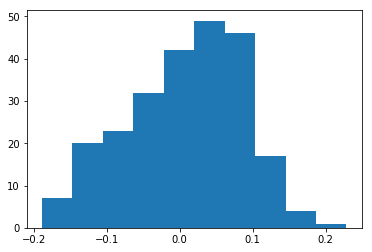

In [161]:
plt.hist(all_scores)

In [164]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

In [166]:
all_scores = np.array(all_scores)

In [167]:
all_probs = sigmoid(all_scores)

(array([ 7., 20., 23., 32., 42., 49., 46., 16.,  5.,  1.]),
 array([0.45294577, 0.4633427 , 0.47373962, 0.48413658, 0.4945335 ,
        0.50493044, 0.5153274 , 0.5257243 , 0.53612125, 0.54651815,
        0.5569151 ], dtype=float32),
 <a list of 10 Patch objects>)

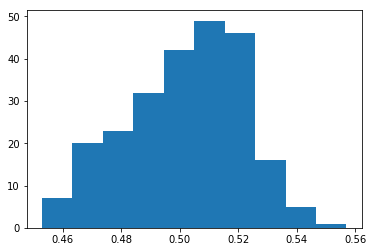

In [169]:
plt.hist(all_probs)

In [170]:
p, r, t = precision_recall_curve(marked_labels, all_probs)

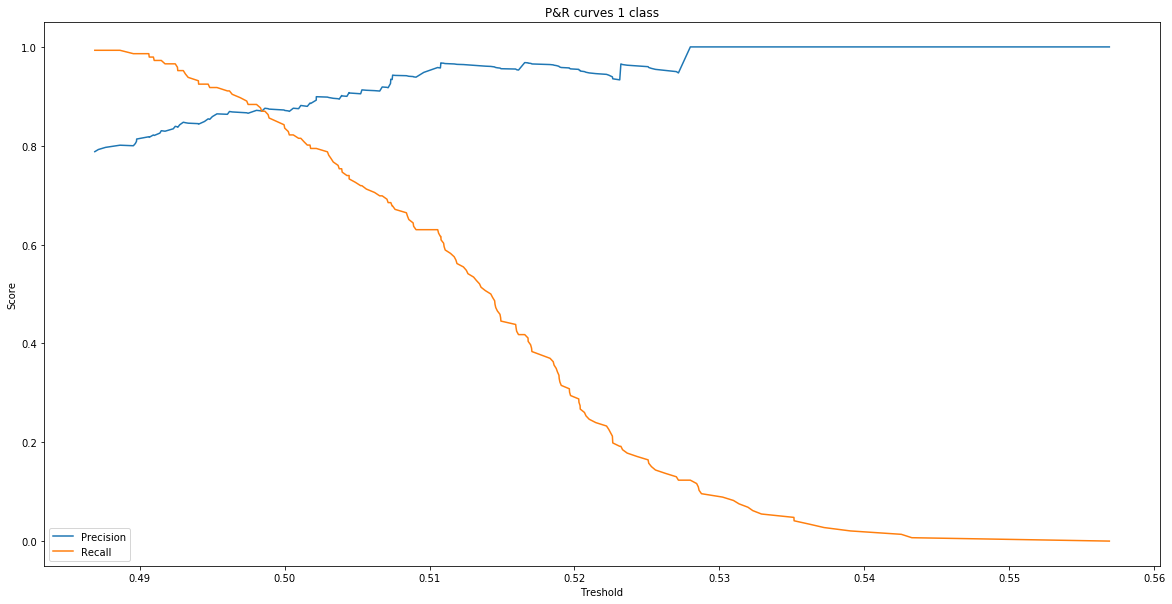

In [171]:
plt.figure(figsize=(20, 10))
plt.title('P&R curves 1 class')
plt.plot(t, p[1:], label='Precision')
plt.plot(t, r[1:], label='Recall')
plt.xlabel('Treshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()